In [1]:
import pandas as pd
import sys

embedding_dir = '../patch_embeddings/'
slide_20X_df = pd.read_hdf(embedding_dir+'20Xslide_embeding.h5')
slide_10X_df = pd.read_hdf(embedding_dir+'10Xslide_embeding.h5')
slide_5X_df = pd.read_hdf(embedding_dir+'5Xslide_embeding.h5')

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from MLP import MLPModel

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

sys.path.append('..')
from utils.train_utils import CustomDataset
slide_embed = slide_20X_df.iloc[:, :768]
dataset = CustomDataset(slide_embed, slide_20X_df.drug_response)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

In [3]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * features.size(0)
        preds = torch.round(torch.sigmoid(outputs)).detach().cpu().numpy()  # Detach before converting to numpy
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, f1, auc

def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * features.size(0)

            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, f1, auc


In [4]:

import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPModel(input_dim=768, hidden_dims=[512, 256, 128], output_dim=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss combines Sigmoid and BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
for epoch in range(num_epochs):
    print(f'--Start Epoch {epoch+1}/{num_epochs}--')
    train_loss, train_acc, train_f1, train_auc = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_auc = validate_model(model, test_loader, criterion, device)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Epoch {epoch + 1}/{num_epochs}, Valid Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

--Start Epoch 1/300--
Epoch 1/300, Train Loss: 0.6705, Acc: 0.6628, F1: 0.0333, AUC: 0.4767
Epoch 1/300, Valid Loss: 0.6665, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
--Start Epoch 2/300--
Epoch 2/300, Train Loss: 0.6306, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 2/300, Valid Loss: 0.6284, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
--Start Epoch 3/300--
Epoch 3/300, Train Loss: 0.6458, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 3/300, Valid Loss: 0.6299, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
--Start Epoch 4/300--
Epoch 4/300, Train Loss: 0.6391, Acc: 0.6977, F1: 0.0000, AUC: 0.4959
Epoch 4/300, Valid Loss: 0.6374, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
--Start Epoch 5/300--
Epoch 5/300, Train Loss: 0.6350, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 5/300, Valid Loss: 0.6376, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
--Start Epoch 6/300--
Epoch 6/300, Train Loss: 0.6328, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 6/300, Valid Loss: 0.6355, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
--Start Epoch 7/300--
Epoch 

In [5]:
import sys
sys.path.append('..')
from utils.train_utils import plot_cross_validation_results

In [6]:
import numpy as np
from sklearn.model_selection import KFold

def cross_validate_model(dataframe, labels, input_dim, hidden_dims, output_dim, num_epochs, batch_size, k_folds=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.BCEWithLogitsLoss()

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataframe)):
        print(f'-- Fold {fold + 1}/{k_folds} --')

        train_dataset = CustomDataset(dataframe.iloc[train_idx], labels.iloc[train_idx])
        val_dataset = CustomDataset(dataframe.iloc[val_idx], labels.iloc[val_idx])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = MLPModel(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            train_loss, train_acc, train_f1, train_auc = train_model(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc, val_f1, val_auc = validate_model(model, val_loader, criterion, device)
            
            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
            print(f'Epoch {epoch + 1}/{num_epochs}, Valid Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')

        fold_results.append({
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'train_auc': train_auc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_auc': val_auc
        })

    # Calculate average results across folds
    avg_results = {
        'train_loss': np.mean([result['train_loss'] for result in fold_results]),
        'train_acc': np.mean([result['train_acc'] for result in fold_results]),
        'train_f1': np.mean([result['train_f1'] for result in fold_results]),
        'train_auc': np.mean([result['train_auc'] for result in fold_results]),
        'val_loss': np.mean([result['val_loss'] for result in fold_results]),
        'val_acc': np.mean([result['val_acc'] for result in fold_results]),
        'val_f1': np.mean([result['val_f1'] for result in fold_results]),
        'val_auc': np.mean([result['val_auc'] for result in fold_results])
    }

    print("\nAverage Results across all folds:")
    print(f"Train Loss: {avg_results['train_loss']:.4f}")
    print(f"Train Accuracy: {avg_results['train_acc']:.4f}")
    print(f"Train F1 Score: {avg_results['train_f1']:.4f}")
    print(f"Train AUC: {avg_results['train_auc']:.4f}")
    print(f"Validation Loss: {avg_results['val_loss']:.4f}")
    print(f"Validation Accuracy: {avg_results['val_acc']:.4f}")
    print(f"Validation F1 Score: {avg_results['val_f1']:.4f}")
    print(f"Validation AUC: {avg_results['val_auc']:.4f}")

    return fold_results


# Set parameters
input_dim = 768
hidden_dims = [512, 256, 128]
output_dim = 1
num_epochs = 300
batch_size = 1
k_folds = 5

# Perform cross-validation
results = cross_validate_model(slide_embed, slide_20X_df.drug_response, input_dim, hidden_dims, output_dim, num_epochs, batch_size, k_folds)


-- Fold 1/5 --


Epoch 1/300, Train Loss: 0.7374, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 1/300, Valid Loss: 0.6583, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 2/300, Train Loss: 0.6591, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 2/300, Valid Loss: 0.6411, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 3/300, Train Loss: 0.6304, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 3/300, Valid Loss: 0.6401, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 4/300, Train Loss: 0.6295, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 4/300, Valid Loss: 0.6637, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 5/300, Train Loss: 0.6205, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 5/300, Valid Loss: 0.6373, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 6/300, Train Loss: 0.6147, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 6/300, Valid Loss: 0.6465, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 7/300, Train Loss: 0.6299, Acc: 0.7035, F1: 0.0000, AUC: 0.5000
Epoch 7/300, Valid Loss: 0.6428, Acc: 0.6744, F1: 0.0000, AUC: 0.5000
Epoch 8/300, Train L

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


AttributeError: 'list' object has no attribute 'melt'

<Figure size 1200x800 with 0 Axes>

In [13]:
# fold0
# Epoch 248/300, Train Loss: 0.4380, Acc: 0.7907, F1: 0.7143, AUC: 0.8172
# Epoch 248/300, Valid Loss: 4.2069, Acc: 0.6744, F1: 0.5882, AUC: 0.6847
# fold 1
# Epoch 262/300, Train Loss: 0.2750, Acc: 0.8605, F1: 0.7895, AUC: 0.8619
# Epoch 262/300, Valid Loss: 1.4849, Acc: 0.7209, F1: 0.4545, AUC: 0.6256
#fold3
#Epoch 257/300, Train Loss: 0.3390, Acc: 0.8198, F1: 0.7257, AUC: 0.8249
# Epoch 257/300, Valid Loss: 0.6847, Acc: 0.7209, F1: 0.5714, AUC: 0.6759
#fold4
# Epoch 296/300, Train Loss: 0.3854, Acc: 0.7907, F1: 0.7273, AUC: 0.8079
# Epoch 296/300, Valid Loss: 0.6474, Acc: 0.5814, F1: 0.4706, AUC: 0.6944
#fold
# Epoch 269/300, Train Loss: 0.4055, Acc: 0.7674, F1: 0.7015, AUC: 0.8061
# Epoch 269/300, Valid Loss: 0.6242, Acc: 0.5349, F1: 0.5455, AUC: 0.6449

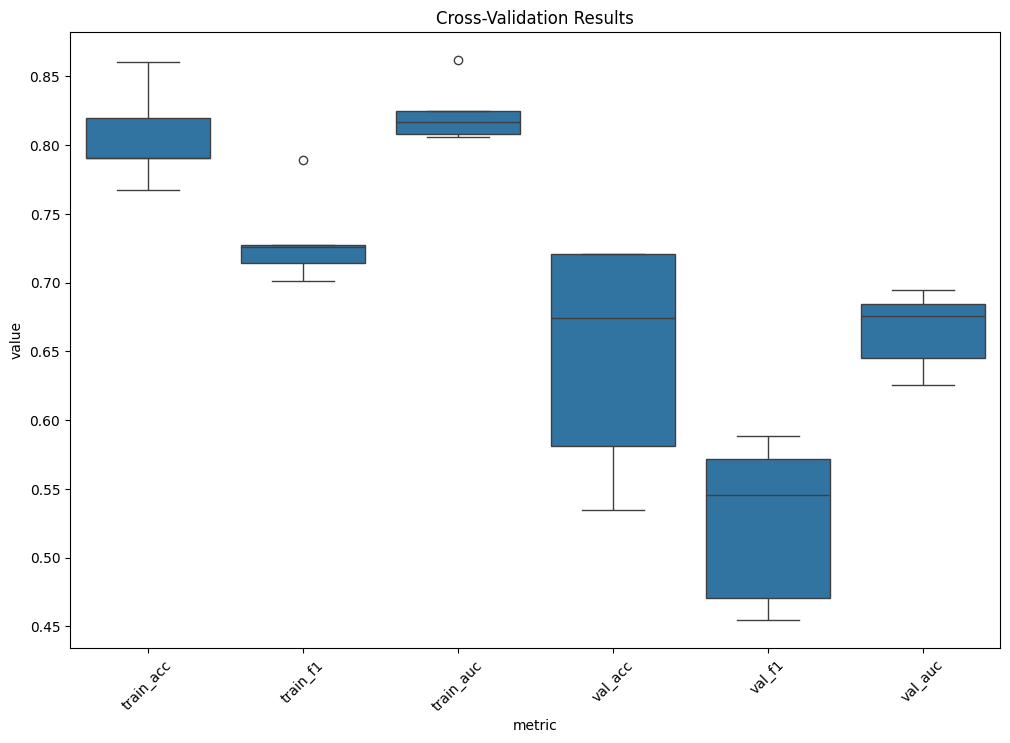

In [16]:
results=[{
    'fold':0,
    'train_loss': 0.43,
  'train_acc': 0.7907,
  'train_f1': 0.7143,
  'train_auc': 0.8172,
  'val_loss': 4.2069,
  'val_acc': 0.6744,
  'val_f1': 0.5882,
  'val_auc': 0.6847},
 {
         'fold':1,

     'train_loss': 0.2750,
  'train_acc': 0.8605,
  'train_f1': 0.7895,
  'train_auc': 0.8619,
  'val_loss': 1.4849,
  'val_acc': 0.7209,
  'val_f1': 0.4545,
  'val_auc': 0.6256},
 {
         'fold':2,
     'train_loss': 0.3390,
  'train_acc': 0.8198,
  'train_f1': 0.7257,
  'train_auc': 0.8249,
  'val_loss': 0.6847,
  'val_acc': 0.7209,
  'val_f1': 0.5714,
  'val_auc': 0.6759},
 {
         'fold':3,
     'train_loss': 0.3854,
  'train_acc': 0.7907,
  'train_f1': 0.7273,
  'train_auc': 0.8079,
  'val_loss': 0.6474,
  'val_acc': 0.5814,
  'val_f1': 0.4706,
  'val_auc': 0.6944},
 {    'fold':4,
     'train_loss': 0.4055, 
  'train_acc': 0.7674,
  'train_f1': 0.7015,
  'train_auc': 0.80615,
  'val_loss': 0.6242,
  'val_acc': 0.5349,
  'val_f1': 0.5455,
  'val_auc': 0.6449}]
#fold4
# Epoch 296/300, Train Loss: 0.3854, Acc: 0.7907, F1: 0.7273, AUC: 0.8079
# Epoch 296/300, Valid Loss: 0.6474, Acc: 0.5814, F1: 0.4706, AUC: 0.6944
import matplotlib.pyplot as plt
import seaborn as sns
def plot_cross_validation_results(results_df):
    plt.figure(figsize=(12, 8))
    # metrics = ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc']
    metrics = ['train_acc', 'train_f1', 'train_auc', 'val_acc', 'val_f1', 'val_auc']

    results_melted = results_df.melt(id_vars=['fold'], value_vars=metrics, var_name='metric', value_name='value')
    sns.boxplot(x='metric', y='value', data=results_melted)
    plt.xticks(rotation=45)
    plt.title('Cross-Validation Results')
    plt.show()

plot_cross_validation_results(pd.DataFrame(results))


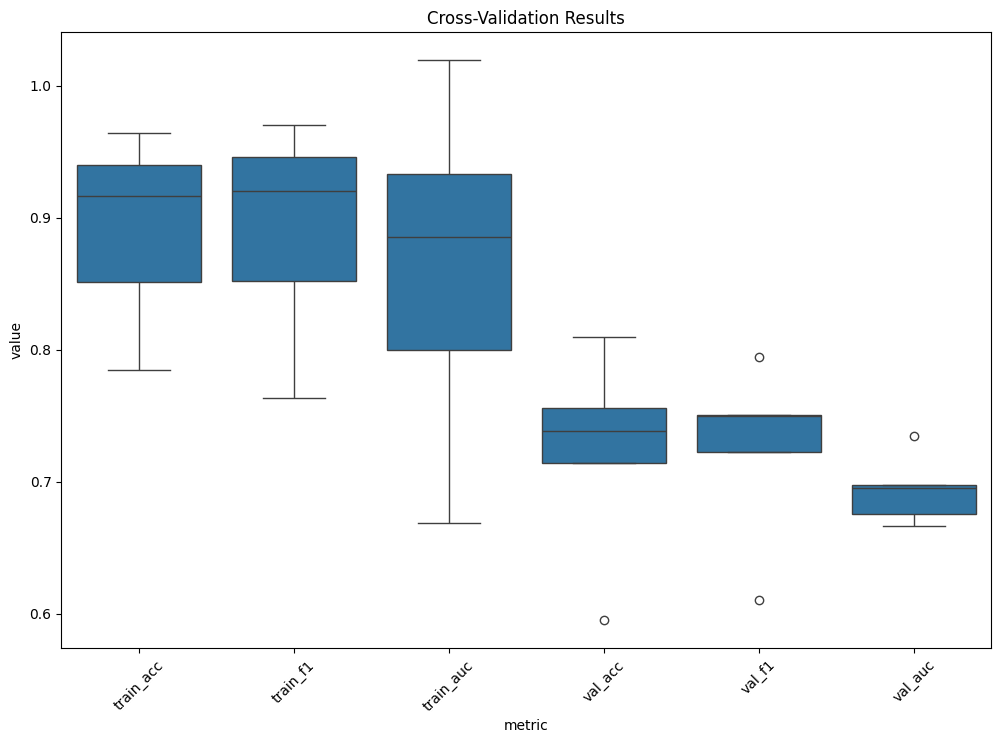

In [18]:
# Epoch 52/100, Train Loss: 0.1270, Acc: 0.9401, F1: 0.9456, AUC: 0.9328
# Epoch 52/100, Valid Loss: 0.7002, Acc: 0.8095, F1: 0.7941, AUC: 0.6950

# Epoch 64/100, Train Loss: 0.4438, Acc: 0.7844, F1: 0.7636, AUC: 0.6688
# Epoch 64/100, Valid Loss: 0.7932, Acc: 0.7143, F1: 0.7227, AUC: 0.6759

# Epoch 64/100, Train Loss: 0.1905, Acc: 0.9162, F1: 0.9198, AUC: 0.8851
# Epoch 64/100, Valid Loss: 1.4678, Acc: 0.5952, F1: 0.6104, AUC: 0.6667

# Epoch 72/100, Train Loss: 0.4271, Acc: 0.8512, F1: 0.8521, AUC: 0.7997
# Epoch 72/100, Valid Loss: 0.8073, Acc: 0.7561, F1: 0.7501, AUC: 0.6978

# Epoch 45/100, Train Loss: 0.0941, Acc: 0.9641, F1: 0.9698, AUC: 0.9614
# Epoch 45/100, Valid Loss: 1.0193, Acc: 0.7381, F1: 0.7509, AUC: 0.7346

results=[{
    'fold':0,
    'train_loss': 0.1270,
  'train_acc': 0.9401,
  'train_f1': 0.9456,
  'train_auc': 0.9328,
  'val_loss': 0.7002,
  'val_acc': 0.8095,
  'val_f1': 0.7941,
  'val_auc': 0.6950},
 {
         'fold':1,
     'train_loss': 0.4438,
  'train_acc': 0.7844,
  'train_f1': 0.7636,
  'train_auc': 0.6688,
  'val_loss': 0.7932,
  'val_acc': 0.7143,
  'val_f1': 0.7227,
  'val_auc':0.6759},
 {
         'fold':2,
     'train_loss': 0.1905,
  'train_acc': 0.9162,
  'train_f1': 0.9198,
  'train_auc': 0.8851,
  'val_loss': 1.4678,
  'val_acc': 0.5952,
  'val_f1': 0.6104,
  'val_auc': 0.6667},
 {
         'fold':3,
     'train_loss': 0.4271,
  'train_acc': 0.8512,
  'train_f1': 0.8521,
  'train_auc': 0.7997,
  'val_loss': 0.8073,
  'val_acc': 0.7561,
  'val_f1': 0.7501,
  'val_auc': 0.6978},
 {    'fold':4,
     'train_loss': 0.0941, 
  'train_acc':0.9641,
  'train_f1': 0.9698,
  'train_auc': 1.0193,
  'val_loss': 1.0193,
  'val_acc': 0.7381,
  'val_f1': 0.7509,
  'val_auc': 0.7346}]

import matplotlib.pyplot as plt
import seaborn as sns
def plot_cross_validation_results(results_df):
    plt.figure(figsize=(12, 8))
    # metrics = ['train_loss', 'train_acc', 'train_f1', 'train_auc', 'val_loss', 'val_acc', 'val_f1', 'val_auc']
    metrics = ['train_acc', 'train_f1', 'train_auc', 'val_acc', 'val_f1', 'val_auc']

    results_melted = results_df.melt(id_vars=['fold'], value_vars=metrics, var_name='metric', value_name='value')
    sns.boxplot(x='metric', y='value', data=results_melted)
    plt.xticks(rotation=45)
    plt.title('Cross-Validation Results')
    plt.show()

plot_cross_validation_results(pd.DataFrame(results))
